Write a program to extract AVHRR sensor images from files containing recording of HRPT downlink stream from NOAA-18/19 satellites. 

These files contain sequence of HRPT 10bit words stored in least significant bits of 16bit integers (using little-endian integer format). Ramaining 6 MSB are filled with 0.  So the file is a sequence of 16 bit integers, one number per HRPT word. 

You should decode and extract all available AVHRR image lines, select any 3 channels and save output RGB image in common image format (JPEG or PNG).

NOAA_RGB_sample.jpg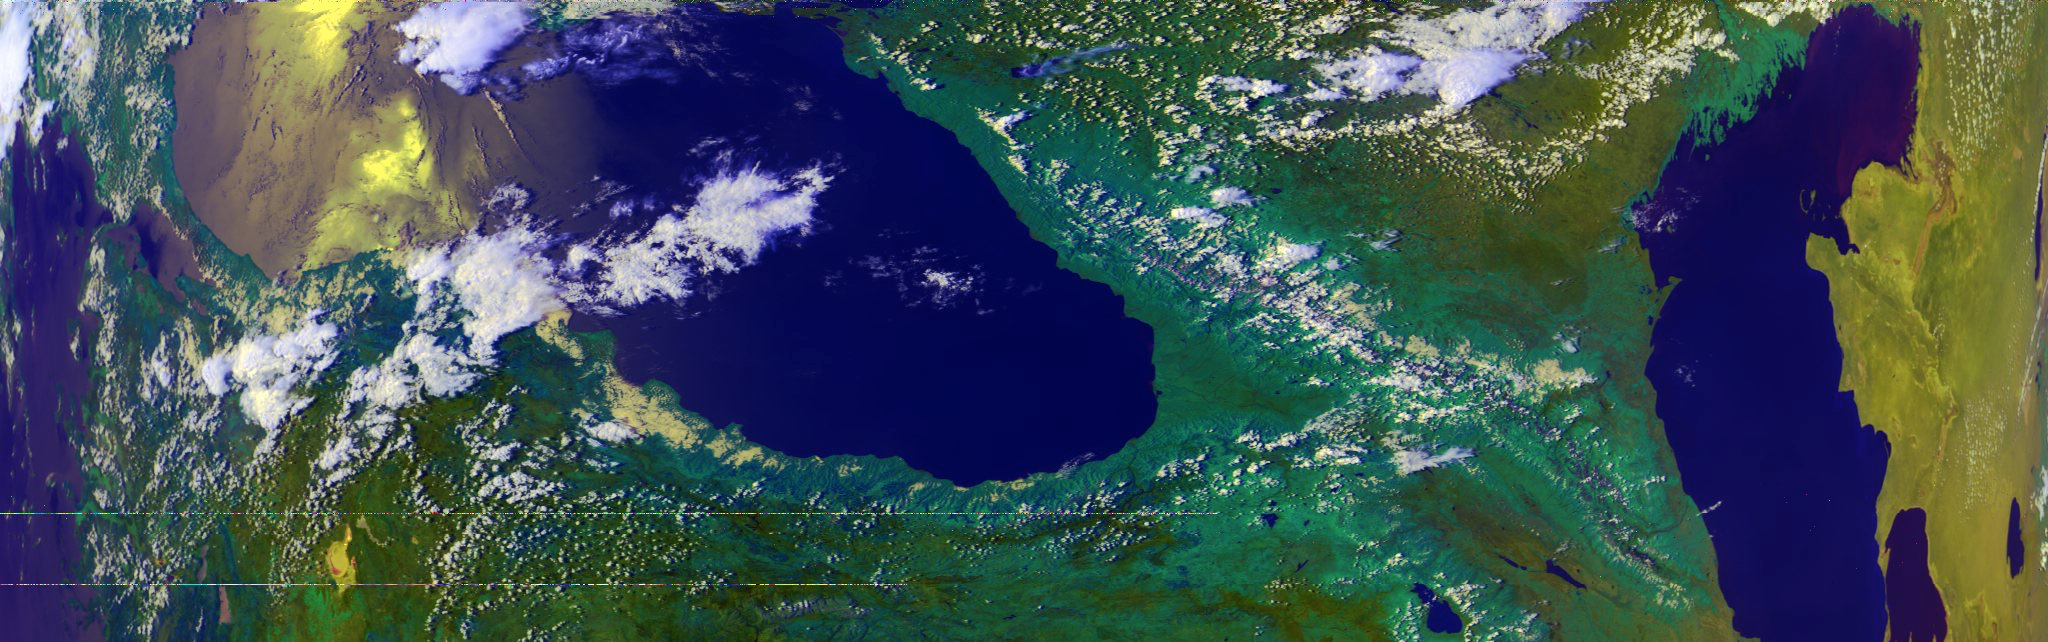

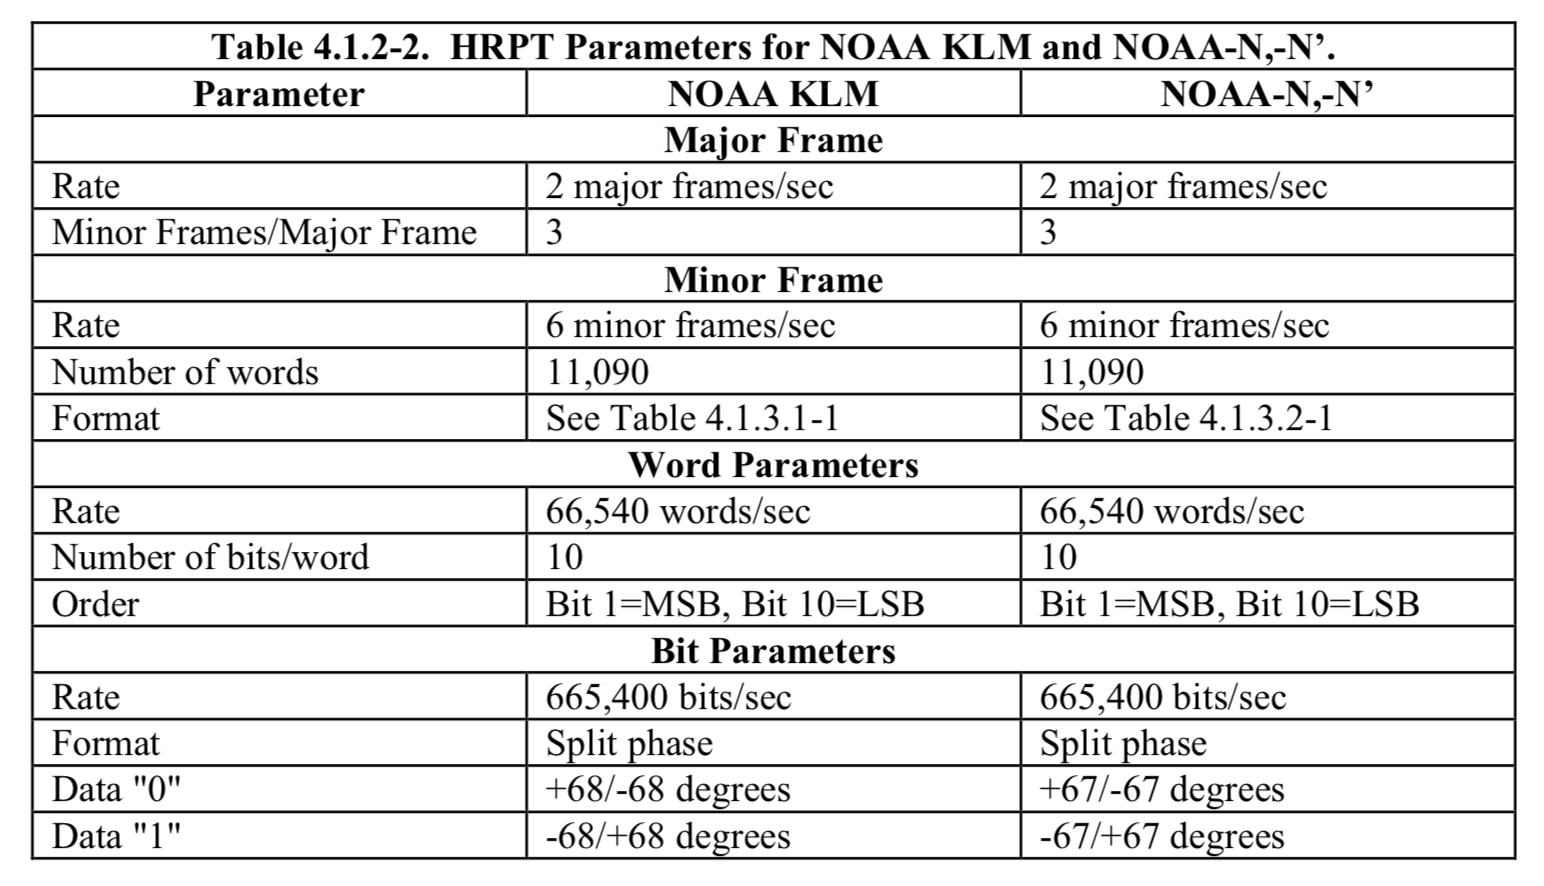

On NOAA KLM, TIP and AMSU data are updated at the major frame rate. That is, the three minor frames which make up the major frame will contain TIP data in the first minor frame, backfill in the second minor frame, and AMSU data from the AIP, in the third minor frame.



In [154]:
import numpy as np
from pathlib import Path
import struct
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from skimage import exposure, data, filters, io, img_as_float
import cv2
from io import BytesIO
from IPython.display import Image
from ipywidgets import interact, interactive, fixed
import matplotlib as mpl

H - unsigned short (0, 255) - integer - 2 bytes

In [2]:
data = Path("./NOAA_HRPT/20180715_015444_NOAA19.raw16").read_bytes()  # Python 3.5+

In [141]:
bands = 5
pixels_in_row = 2048
words_in_frame = 11090
earth_data = 10240
words_total = int(len(data)/2)
frames = int(words_total/words_in_frame)
print("frames total:", int(frames))
print("words total:", words_total)
print("check:", int(words_in_frame * frames))
print("check2:", frames * pixels_in_row * bands + (words_in_frame - earth_data)*frames)

frames total: 729
words total: 8084610
check: 8084610
check2: 8084610


In [6]:
arr = np.zeros(words_total, dtype=np.uint16)

for i in range(words_total):
    arr[i] = struct.unpack('<H', data[2*i: 2*i + 2])[0]

In [7]:
print("First 6 symbols are: \n", arr[0:6])
print(" ")

print("They are exactly Frame Sync words:")
for i in arr[0:6]:
    print("{0:b}".format(i))

First 6 symbols are: 
 [644 367 860 413 527 149]
 
They are exactly Frame Sync words:
1010000100
101101111
1101011100
110011101
1000001111
10010101


In [8]:
full_scan = np.reshape(arr, (frames, words_in_frame))  # 729 frames with 11090 in each
full_scan.shape

(729, 11090)

In [9]:
B1 = full_scan[0][751:10991:5]
B2 = full_scan[0][752:10991:5]
B3 = full_scan[0][753:10991:5]
B4 = full_scan[0][754:10991:5]
B5 = full_scan[0][755:10991:5]

for line in full_scan[1:]:
    B1 = np.vstack((B1, line[751:10991:5]))
    B2 = np.vstack((B2, line[752:10991:5]))
    B3 = np.vstack((B3, line[753:10991:5]))
    B4 = np.vstack((B4, line[754:10991:5]))
    B5 = np.vstack((B5, line[755:10991:5]))

(729, 2048)
[[23 24 23 ... 48 47 46]
 [22 22 24 ... 47 46 46]
 [30 22 22 ... 45 45 45]
 ...
 [53 50 48 ... 47 48 49]
 [52 49 47 ... 32  0 48]
 [52 48 47 ... 43 44 46]]


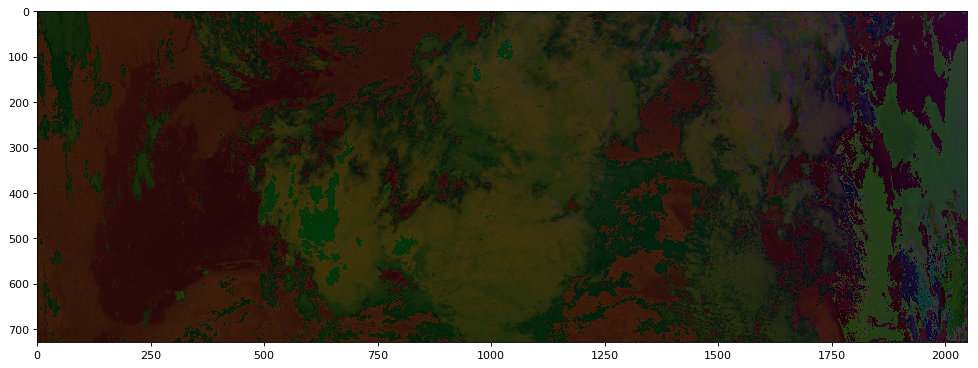

In [228]:
# from scipy.interpolate import interp1d
# m = interp1d([1,512],[5,10])
# m(256)

def my_map(x, in_min, in_max, out_min, out_max):
    if len(x.shape) == 2:
        shape_x = x.shape
        x_ = np.array(x.flatten())
        x_m = (x_-in_min) * (out_max-out_min) / (in_max-in_min) + out_min  # mapped
        x_mr = x_m.reshape(shape_x) # mapped and reshaped
        return x_mr.astype(np.uint8)
    elif len(x.shape) == 1:
        return int((x-in_min) * (out_max-out_min) / (in_max-in_min) + out_min)  # mapped


# starting from the shortest wavelength
r = B3
g = B2
b = B1

# print(type(r))
# print(len(r.shape))
# print(np.array(r.flatten().shape))
# print(r.shape)

rm = my_map(r, 0, 1024, 0, 255)
gm = my_map(g, 0, 1024, 0, 255)
bm = my_map(b, 0, 1024, 0, 255)

print(rm.shape)
print(rm)

rgb = np.dstack((rm, gm, bm))  # stacks 3 h x w arrays -> h x w x 3
rgb.shape

figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(rgb)

# plt.imshow(rgb.astype(np.uint8))
plt.show()
mpl.image.imsave('raw.png', rgb)

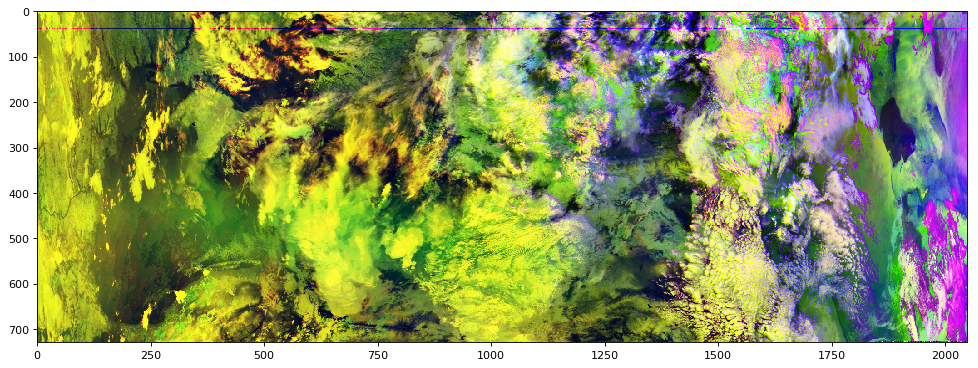

In [231]:
# Parameters
clip_limit=0.1

# Histogram adaptive equalization
rgb[:, :, 0] = exposure.equalize_adapthist(r, clip_limit=clip_limit) * 255
rgb[:, :, 1] = exposure.equalize_adapthist(g, clip_limit=clip_limit) * 255
rgb[:, :, 2] = exposure.equalize_adapthist(b, clip_limit=clip_limit) * 255

figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')

#plt.imshow(rgb.astype(np.uint8))
plt.imshow(rgb)

plt.show()
mpl.image.imsave('eqzd.png', rgb)

In [166]:
def white_balance(img):
    result = cv.cvtColor(img, cv.COLOR_BGR2LAB)
    avg_a = np.average(result[:, :, 1])
    avg_b = np.average(result[:, :, 2])
    result[:, :, 1] = result[:, :, 1] - ((avg_a - 128) * (result[:, :, 0] / 255.0) * 1.1)
    result[:, :, 2] = result[:, :, 2] - ((avg_b - 128) * (result[:, :, 0] / 255.0) * 1.1)
    result = cv.cvtColor(result, cv.COLOR_LAB2BGR)
    result = cv.cvtColor(result, cv.COLOR_BGR2RGB)
    return result

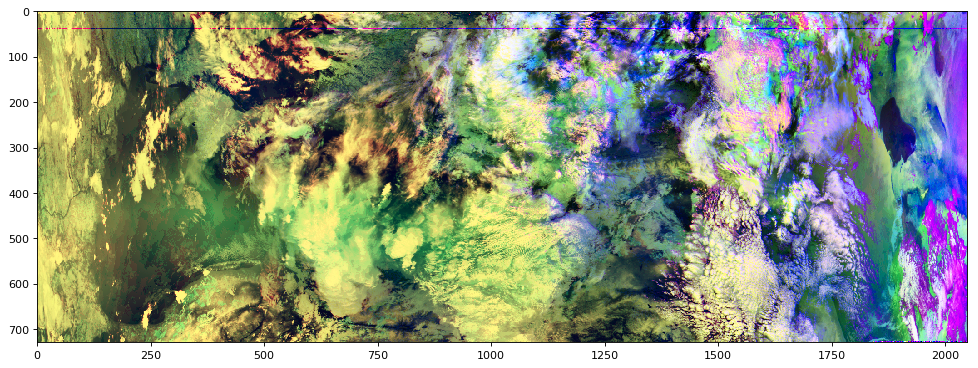

In [242]:
figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')

img=cv2.imread('eqzd.png')
rgb_wb = white_balance(img)
plt.imshow(rgb_wb)
plt.show()
mpl.image.imsave('rgb_wb.png', rgb)

In [239]:
i = data.imread("rgb_wb.png")

In [240]:
def arr2img(arr):
    """Display a 2- or 3-d numpy array as an image."""
    if arr.ndim == 2:
        format, cmap = 'png', mpl.cm.gray
    elif arr.ndim == 3:
        format, cmap = 'jpg', None
    else:
        raise ValueError("Only 2- or 3-d arrays can be displayed as images.")
    # Don't let matplotlib autoscale the color range so we can control overall luminosity
    vmax = 255 if arr.dtype == 'uint8' else 1.0
    with BytesIO() as buffer:
        mpl.image.imsave(buffer, arr, format=format, cmap=cmap, vmin=0, vmax=vmax)
        out = buffer.getvalue()
    return Image(out)

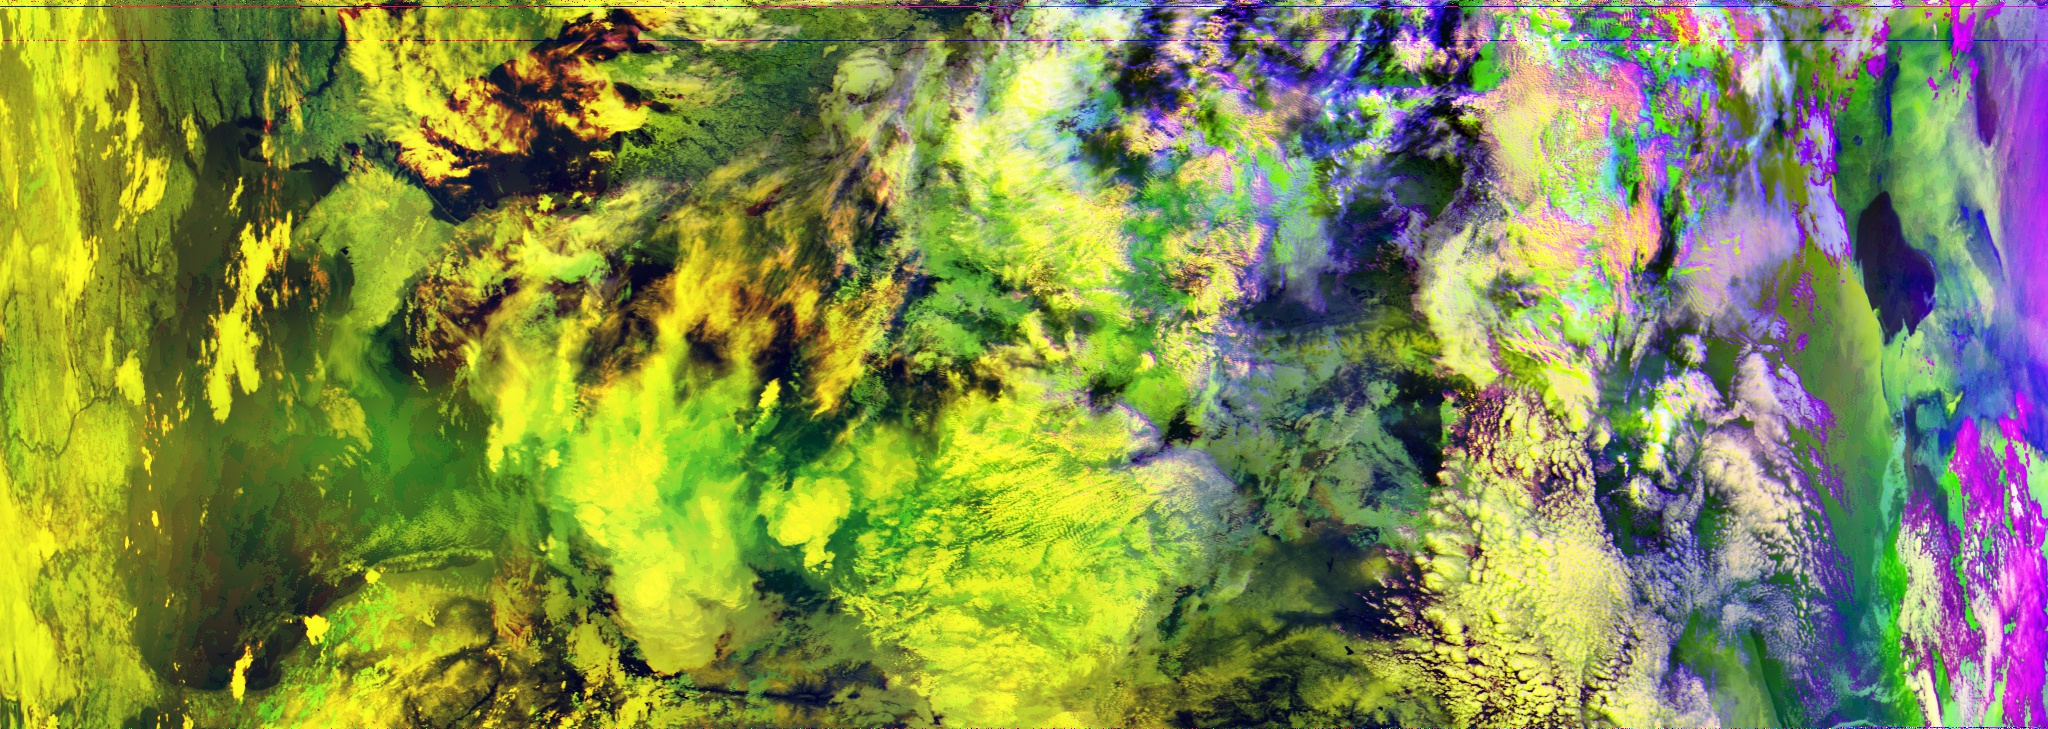

In [243]:
arr2img(i)

In [161]:
def edit_image(image, sigma=0.0, R=1.0, G=1.0, B=1.0):
    new_image = filters.gaussian(image, sigma=sigma, multichannel=True)
    new_image[:,:,0] = R*new_image[:,:,0]
    new_image[:,:,1] = G*new_image[:,:,1]
    new_image[:,:,2] = B*new_image[:,:,2]
    return arr2img(new_image)

In [244]:
lims = (0.0,1.0,0.01)
interact(edit_image, image=fixed(i), sigma=(0.0,10.0,0.1), R=lims, G=lims, B=lims);

interactive(children=(FloatSlider(value=0.0, description='sigma', max=10.0), FloatSlider(value=1.0, descriptio…